# Quora Question Pair Similarity

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re 
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import distance
from fuzzywuzzy import fuzz
import os
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
from scipy import sparse
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

from prettytable import PrettyTable

C:\Users\HP\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Exploratory Data Analysis

In [2]:
df = pd.read_csv("train.csv")
print("Number of data points : ", df.shape[0])

Number of data points :  404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<b>Observations</b>
* One value in question1 column and two values in question2 column are null

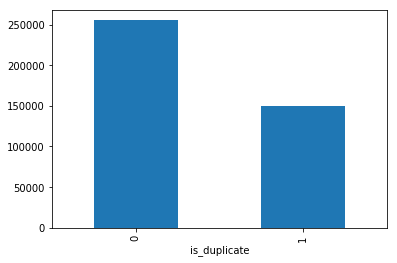

In [5]:
df.groupby("is_duplicate")["id"].count().plot.bar()

<b>Observations</b>
* There are more pair of questions that are not similar.

In [6]:
df["is_duplicate"].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [7]:
print("is_duplicate = 1 : {}%".format(round(df["is_duplicate"].mean()*100, 2)))
print("is_duplicate = 0 : {}%".format(round((1-df["is_duplicate"].mean())*100, 2)))

is_duplicate = 1 : 36.92%
is_duplicate = 0 : 63.08%


In [8]:
q_ids = pd.Series(df["qid1"].tolist() + df["qid2"].tolist())
unique_qs = len(np.unique(q_ids))
print("Total number of unique questions are : {}".format(unique_qs))

Total number of unique questions are : 537933


In [9]:
qs_morethan_onetime = sum(q_ids.value_counts() > 1)
print("Number of unique questions that occur more than one time : {}".format(qs_morethan_onetime))
print("Max number of times a single question is repeated : {}".format(max(q_ids.value_counts())))

Number of unique questions that occur more than one time : 111780
Max number of times a single question is repeated : 157


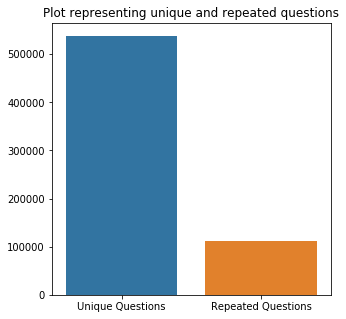

In [10]:
x = ["Unique Questions", "Repeated Questions"]
y = [unique_qs, qs_morethan_onetime]

plt.figure(figsize=(5,5))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x, y)
plt.show()

In [11]:
pair_duplicates = df[["qid1", "qid2", "is_duplicate"]].groupby(["qid1", "qid2"]).count().reset_index()
print("Number of duplicate entries : {}".format(df.shape[0] - pair_duplicates.shape[0]))

Number of duplicate entries : 0


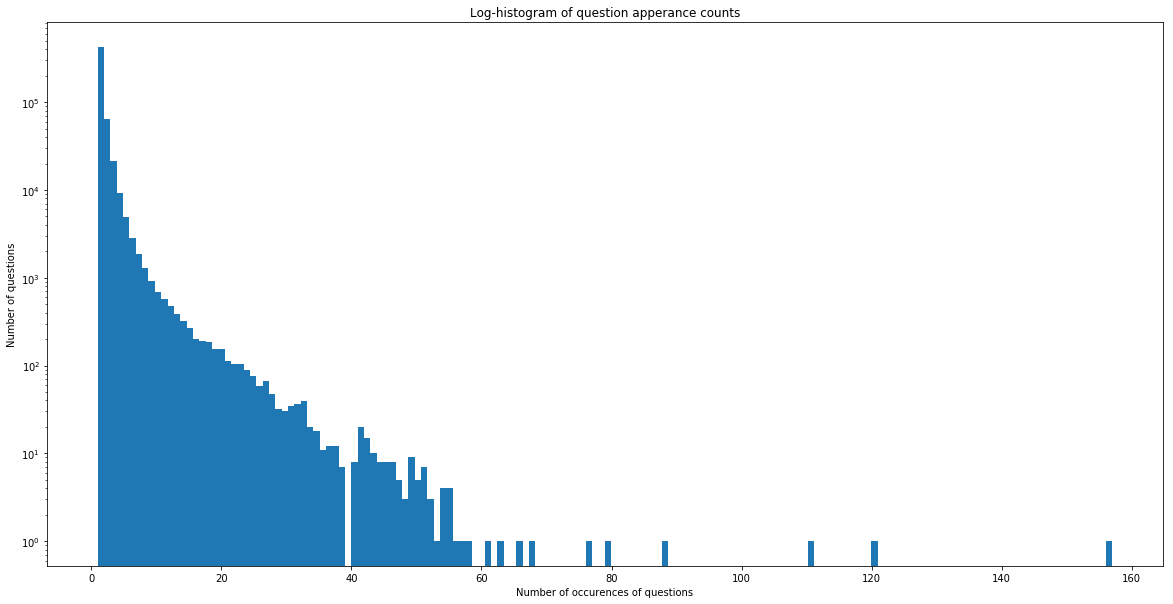

Maximum number of times a single question is repeated : 157


In [12]:
plt.figure(figsize = (20, 10))
plt.hist(q_ids.value_counts(), bins = 160)
plt.yscale('log', nonposy = "clip")
plt.title("Log-histogram of question apperance counts")
plt.xlabel("Number of occurences of questions")
plt.ylabel("Number of questions")
plt.show()
print("Maximum number of times a single question is repeated : {}".format(max(q_ids.value_counts())))

In [13]:
nan_rows = df[df.isnull().any(1)] # 1 for row, 0 for column, default 0
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [14]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# Basic Feature Engineering

In [15]:
if os.path.isfile("df_fe_without_preprocessing_train.csv"):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv")
else:
    df["freq_qid1"] = df.groupby("qid1")["qid1"].transform("count")
    df["freq_qid2"] = df.groupby("qid2")["qid2"].transform("count") 
    df["q1len"] = df["question1"].str.len()
    df["q2len"] = df["question2"].str.len()
    df["q1_n_words"] = df["question1"].apply(lambda row:len(row.split(" ")))
    df["q2_n_words"] = df["question2"].apply(lambda row:len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word : word.lower().strip(), row["question1"].split(" ")))
        w2 = set(map(lambda word : word.lower().strip(), row["question2"].split(" ")))
        return 1.0 * len(w1 & w2)
    df["word_Common"] = df.apply(normalized_word_Common, axis = 1) # axis = 1 means row

    def normalized_word_Total(row):
        w1 = set(map(lambda word : word.lower().strip(), row["question1"].split(" ")))
        w2 = set(map(lambda word : word.lower().strip(), row["question2"].split(" ")))
        return 1.0 * (len(w1) + len(w2))
    df["word_Total"] = df.apply(normalized_word_Total, axis = 1)

    def normalized_word_Share(row):
        return 1 * normalized_word_Common(row)/normalized_word_Total(row)
    df["word_Share"] = df.apply(normalized_word_Share, axis = 1)

    df["freq_q1+freq_q2"] = df["freq_qid1"] + df["freq_qid2"]
    df["freq_q1-freq_q2"] = abs(df["freq_qid1"] - df["freq_qid2"])

    df.to_csv("df_fe_without_preprocessing_train.csv", index = False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [16]:
print("Minimum length of question 1 : ", min(df["q1_n_words"]))
print("Minimum length of question 2 : ", min(df["q2_n_words"]))
print("Number of questions with minimum length [question1] : ",
      df[df["q1_n_words"] == min(df["q1_n_words"])].shape[0])
print("Number of questions with minimum length [question2] : ",
      df[df["q2_n_words"] == min(df["q2_n_words"])].shape[0])

Minimum length of question 1 :  1
Minimum length of question 2 :  1
Number of questions with minimum length [question1] :  67
Number of questions with minimum length [question2] :  24


C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



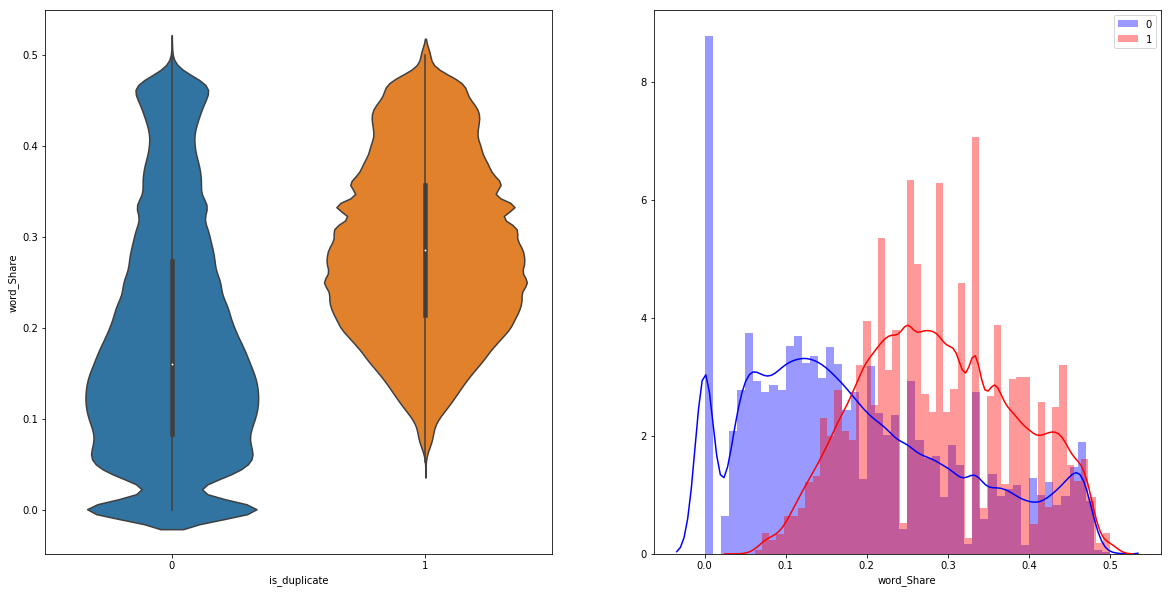

In [17]:
plt.figure(figsize = (20, 10))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "word_Share", data = df)

plt.subplot(122)
sns.distplot(df[df["is_duplicate"] == 0]["word_Share"], label = "0", color = "blue")
sns.distplot(df[df["is_duplicate"] == 1]["word_Share"], label = "1", color = "red")
plt.legend()
plt.show()

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



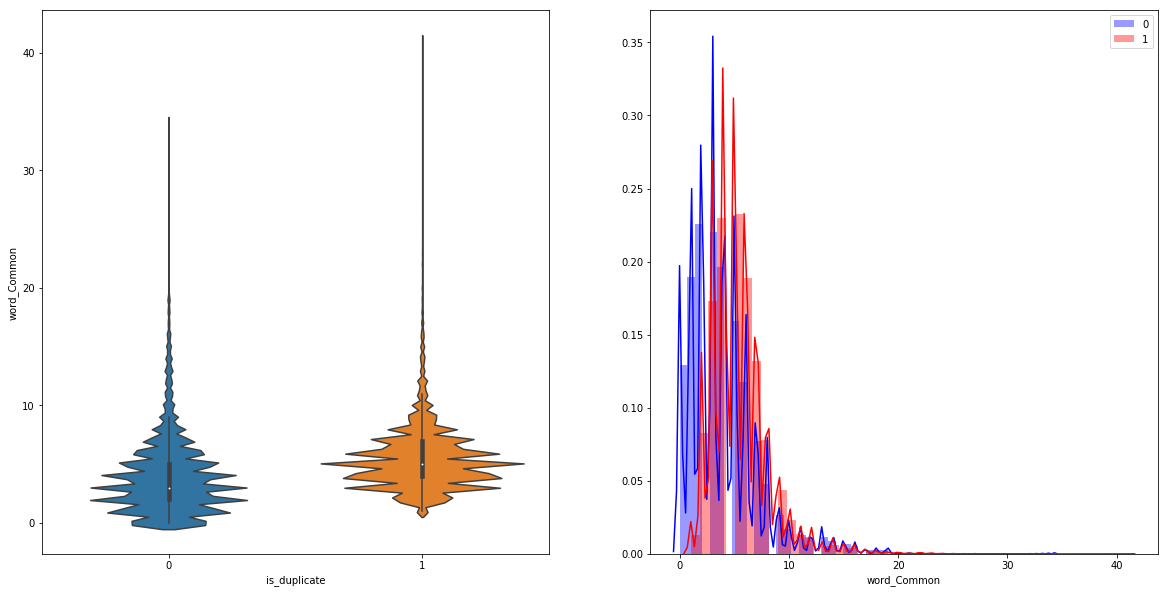

In [18]:
plt.figure(figsize = (20, 10))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "word_Common", data = df)

plt.subplot(122)
sns.distplot(df[df["is_duplicate"] == 0]["word_Common"], label = "0", color = "blue")
sns.distplot(df[df["is_duplicate"] == 1]["word_Common"], label = "1", color = "red")

plt.legend()
plt.show()

# Preprocessing of Text

* Expanding contractions
* Removing html tags
* Removing urls
* Removing punctuations
* Performing Stemming

In [19]:
def preprocess(x): # here x is a complete question
    x = str(x).lower()
    
    # Expanding contractions
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
         .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
         .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
         .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
         .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
         .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
         .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    # Removing html tags
    soup = BeautifulSoup(x, "lxml")
    x = soup.get_text()
    
    # Removing urls
    x = re.sub(r"http\S+", "", x)  # \S+ --> Sequence of non whitespace
    
    # Removing Punctuations [^-]^&$:;~!#%*()+=
    pattern = re.compile("\W+") # \W+ --> non-alphanumeric
    x = re.sub(pattern, " ", x)
    
    # Performing Stemming
    porter = PorterStemmer()
    x = porter.stem(x)
    
    return x

# Advanced Feature Extraction(NLP and Fuzzy Features)


In [20]:
# To get the result in 4 decimal points
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting sentence to tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the Stop Words in questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from question_pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from question_pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common tokens from question_pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count/(min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count/(max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count/(min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count/(max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count/(min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count/(max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both questions is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both questions is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    # Absolute length difference
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average token length of both questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

In [21]:
def get_longest_substr_ratio(a, b):
    substr = list(distance.lcsubstrings(a, b)) # Converting returned set into a list
    if len(substr) == 0:
        return 0
    else:
        return len(substr[0])/(min(len(a), len(b)) + 1)

In [22]:
def extract_features(df):
    # Preprocessing each feature
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    # Merging features with dataset
    token_features = df.apply(lambda x:get_token_features(x["question1"], x["question2"]), axis=1) # axis = 1 means row
    df["cwc_min"] = list(map(lambda x : x[0], token_features))
    df["cwc_max"] = list(map(lambda x : x[1], token_features))
    df["csc_min"] = list(map(lambda x : x[2], token_features))
    df["csc_max"] = list(map(lambda x : x[3], token_features))
    df["ctc_min"] = list(map(lambda x : x[4], token_features))
    df["ctc_max"] = list(map(lambda x : x[5], token_features))
    df["last_word_eq"] = list(map(lambda x : x[6], token_features))
    df["first_word_eq"] = list(map(lambda x : x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x : x[8], token_features))
    df["mean_len"] = list(map(lambda x : x[9], token_features))
    
    # Computing Fuzzy features and merging with dataset
    df["fuzz_ratio"] = df.apply(lambda x : fuzz.QRatio(x["question1"], x["question2"]), axis = 1)
    df["fuzz_partial_ratio"] = df.apply(lambda x : fuzz.partial_ratio(x["question1"], x["question2"]), axis = 1)
    df["fuzz_token_sort_ratio"] = df.apply(lambda x : fuzz.token_sort_ratio(x["question1"], x["question2"]), axis = 1)
    df["fuzz_token_set_ratio"] = df.apply(lambda x : fuzz.token_set_ratio(x["question1"], x["question2"]), axis = 1)
    df["longest_substr_ratio"] = df.apply(lambda x : get_longest_substr_ratio(x["question1"], x["question2"]), axis = 1)
    
    return df

In [23]:
if os.path.isfile("nlp_features_train.csv"):
    df = pd.read_csv("nlp_features_train.csv")
    df.fillna("")
else:
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index = False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,93,100,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,65,73,63,86,0.580000
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,43,47,63,63,0.166667
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,9,14,24,28,0.040000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,36,56,47,67,0.175000


In [24]:
df_duplicate = df[df["is_duplicate"] == 1]
dfp_nonduplicate = df[df["is_duplicate"] == 0]

p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print("Number of data points in class 1 (Duplicate pairs) : ", len(p))
print("Number of data points in class 0 (Non-Duplicate pairs) : ", len(n))

np.savetxt("train_p", p, delimiter = " ", fmt = "%s", encoding = "utf-8")
np.savetxt("train_n", n, delimiter = " ", fmt = "%s", encoding = "utf-8")

Number of data points in class 1 (Duplicate pairs) :  298526
Number of data points in class 0 (Non-Duplicate pairs) :  510054


In [25]:
# Reading the text files and removing the stopwords
d = os.path.dirname(".")
textp_w = open(os.path.join(d, "train_p"), encoding = "utf-8").read()
textn_w = open(os.path.join(d, "train_n"), encoding = "utf-8").read()

stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.discard("not")
stopwords.discard("no")
stopwords.discard("like")

print("Total number of words in duplicate pair questions :", len(textp_w))
print("Total number of words in non-duplicate pair questions :", len(textn_w))

Total number of words in duplicate pair questions : 16039699
Total number of words in non-duplicate pair questions : 32896182


Word Cloud for duplicate question pairs


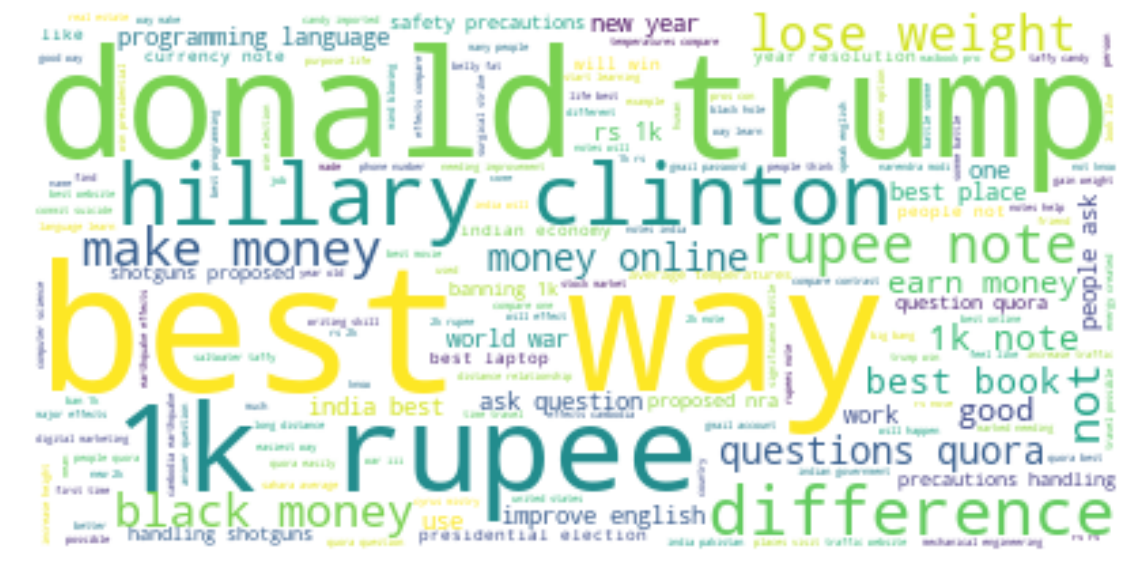

In [26]:
wc = WordCloud(background_color = "white", max_words = len(textp_w), stopwords = stopwords)
wc.generate(textp_w)
plt.figure(figsize = (20, 10))
print("Word Cloud for duplicate question pairs")
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

Word Cloud for non-duplicate question pairs


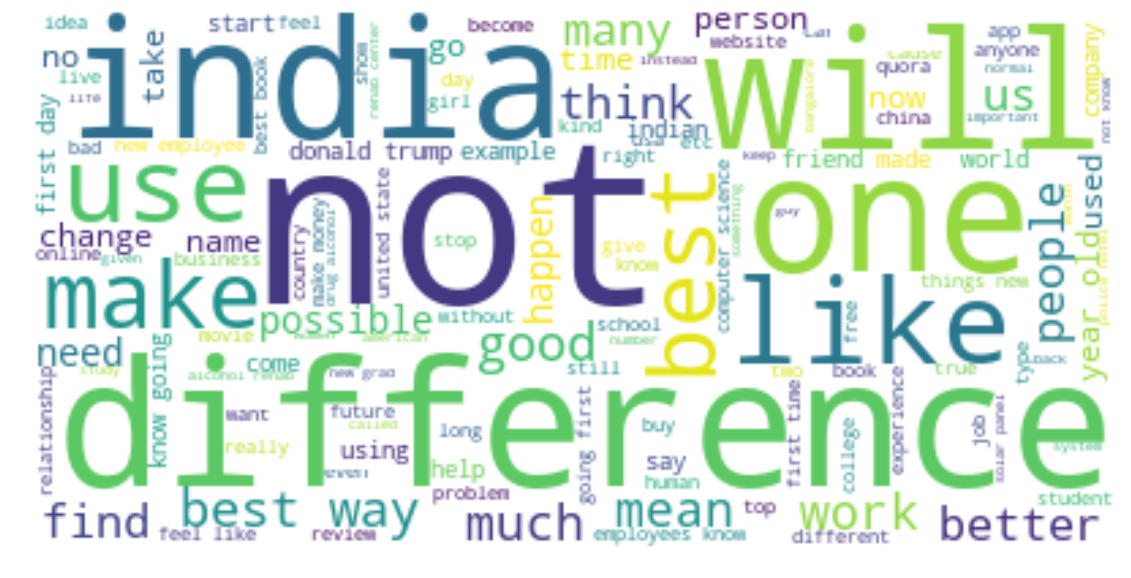

In [27]:
wc = WordCloud(background_color = "white", max_words = len(textn_w), stopwords = stopwords)
wc.generate(textn_w)
plt.figure(figsize = (20, 10))
print("Word Cloud for non-duplicate question pairs")
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

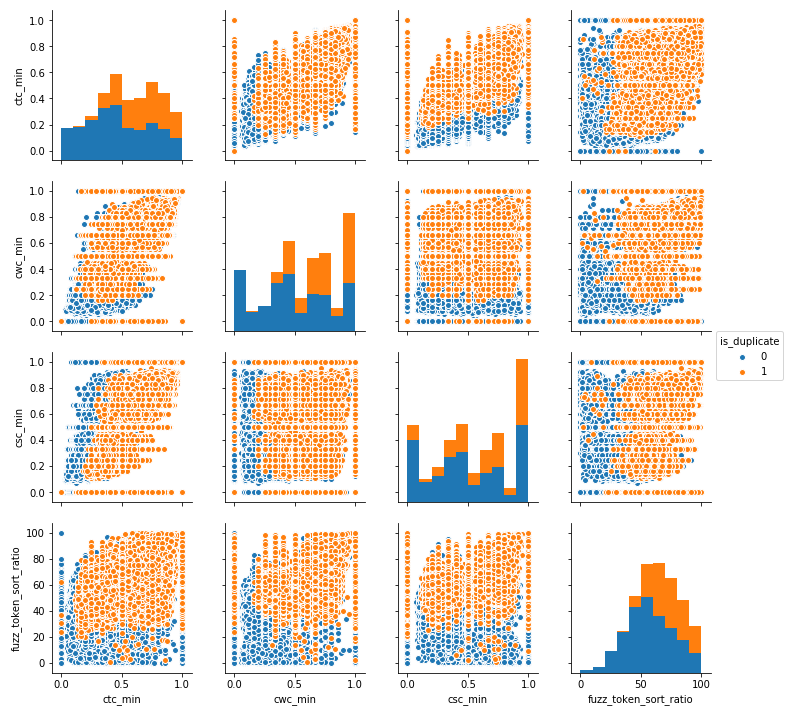

In [28]:
sns.pairplot(df[["ctc_min", "cwc_min", "csc_min", "fuzz_token_sort_ratio", "is_duplicate"]], 
             hue = "is_duplicate", 
             vars = ["ctc_min", "cwc_min", "csc_min", "fuzz_token_sort_ratio"])
plt.show()

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



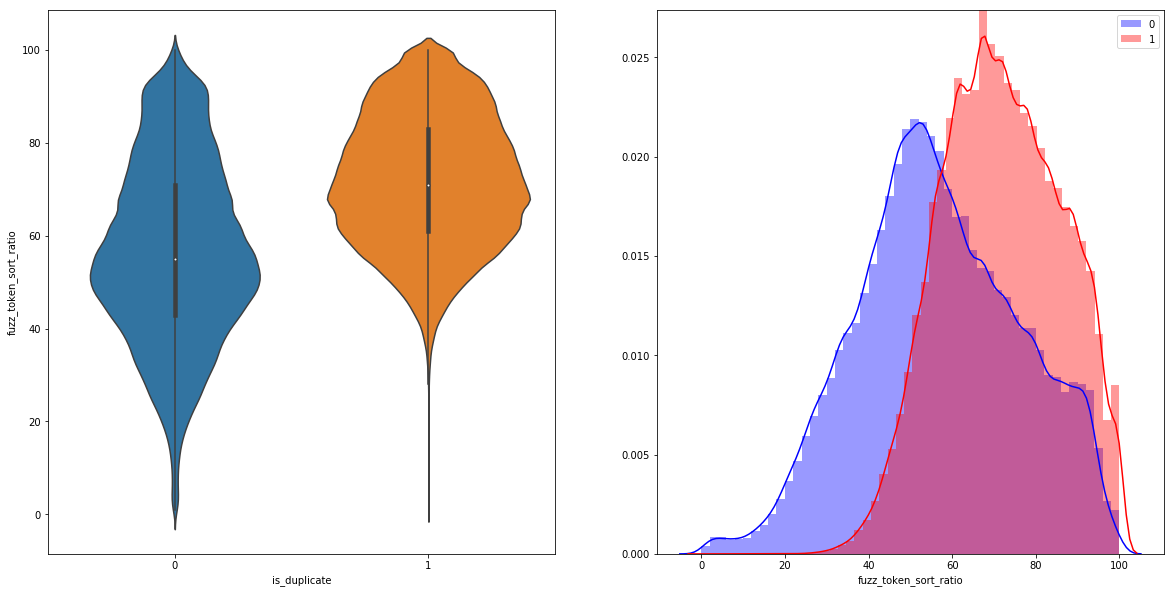

In [29]:
# Distribution of fuzz_token_sort_ratio
plt.figure(figsize = (20,10))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "fuzz_token_sort_ratio", data = df)

plt.subplot(122)
sns.distplot(df[df["is_duplicate"] == 0]["fuzz_token_sort_ratio"], label = "0", color = "blue")
sns.distplot(df[df["is_duplicate"] == 1]["fuzz_token_sort_ratio"], label = "1", color = "red")
plt.legend()

plt.show()

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



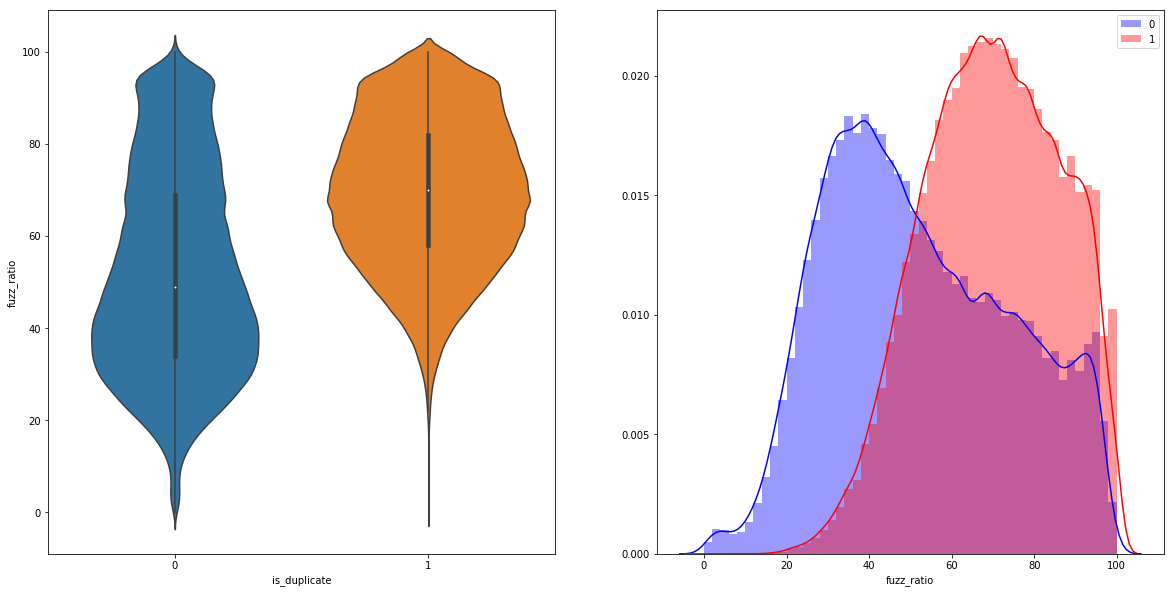

In [30]:
# Distribution of fuzz_ratio
plt.figure(figsize = (20, 10))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "fuzz_ratio", data = df)

plt.subplot(122)
sns.distplot(df[df["is_duplicate"] == 0]["fuzz_ratio"], label = "0", color = "blue")
sns.distplot(df[df["is_duplicate"] == 1]["fuzz_ratio"], label = "1", color = "red")
plt.legend()

plt.show()

# Data Preprocessing

In [31]:
df = pd.read_csv("train.csv")
df_fe_without_preprocessing = pd.read_csv("df_fe_without_preprocessing_train.csv")
df_nlp = pd.read_csv("nlp_features_train.csv")

In [32]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [33]:
df_fe_without_preprocessing.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [34]:
df_fe_without_preprocessing = df_fe_without_preprocessing.drop(["qid1", "qid2", 
                                                                "question1", "question2", 
                                                                "is_duplicate"], axis = 1)

In [35]:
df_nlp.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,93,100,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,65,73,63,86,0.580000
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,43,47,63,63,0.166667
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,9,14,24,28,0.040000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,36,56,47,67,0.175000


In [36]:
df_nlp = df_nlp.drop(["qid1", "qid2", "question1", "question2", "is_duplicate"], axis = 1)

In [37]:
df = df.merge(df_fe_without_preprocessing, on ="id", how = "left")
df = df.merge(df_nlp, on = "id", how = "left")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,longest_substr_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,93,100,93,100,0.982759
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,65,73,63,86,0.580000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,43,47,63,63,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,9,14,24,28,0.040000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,36,56,47,67,0.175000


In [38]:
df = df.sample(n = 100000)
Y = df["is_duplicate"]
df = df.drop(["is_duplicate"], axis = 1)
df = df.fillna(" ")
x_train, x_test, y_train, y_test = train_test_split(df, Y, stratify = Y, test_size = 0.3)
print("Number of points in train data", x_train.shape[0])
print("Number of points in test data", x_test.shape[0])

Number of points in train data 70000
Number of points in test data 30000


In [39]:
x_train["question1"] = x_train["question1"].apply(lambda x: str(x))
x_train["question2"] = x_train["question2"].apply(lambda x: str(x))
questions = list(x_train["question1"]) + list(x_train["question2"])
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [40]:
x_train.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,longest_substr_ratio
228811,228811,337981,337982,What are the best ways to make a fool of yours...,A worker who sits next to me in a cubicle make...,1,1,70,159,15,...,0.199999,0.0,0.0,20.0,25.0,35,49,45,57,0.257143
235501,235501,346227,346228,Which is the best book for chemical kinetics f...,What are the best books for chemical kinetics ...,1,1,61,61,10,...,0.599994,1.0,0.0,0.0,10.0,87,87,87,90,0.370968
377416,377416,508713,508714,I can't afford taking piano lessons.Should I l...,Should I take piano lessons?,1,1,80,28,14,...,0.249998,0.0,0.0,11.0,10.5,35,75,50,90,0.517241
7655,7655,14948,14949,What is the most demanded software skills in USA?,What type of software engineer has the most de...,1,2,49,71,9,...,0.333331,0.0,1.0,3.0,10.5,49,57,64,64,0.340000
7025,7025,13744,13745,How can a mechanical engineer graduate from In...,Can an Indian graduating in mechanical engine...,1,1,88,97,15,...,0.466664,1.0,0.0,1.0,14.5,65,70,81,83,0.224719


In [41]:
x_train_sparse_matrix1 = tf_idf_vect.transform(x_train["question1"].values)
x_train_sparse_matrix2 = tf_idf_vect.transform(x_train["question2"].values)
x_train_sparse_matrix=sparse.hstack([x_train_sparse_matrix1, x_train_sparse_matrix2])
x_train_sparse_matrix.shape
#x_train_sparse_matrix=sparse.hstack([x_train_sparse_matrix, x_train["freq_qid1"].values[:,None]])

(70000, 77458)

In [42]:
x_train = x_train.drop(["id", "qid1", "qid2", "question1", "question2"], axis = 1)
x_train.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,freq_q1+freq_q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,longest_substr_ratio
228811,1,1,70,159,15,35,7.0,42.0,0.166667,2,...,0.199999,0.0,0.0,20.0,25.0,35,49,45,57,0.257143
235501,1,1,61,61,10,10,6.0,19.0,0.315789,2,...,0.599994,1.0,0.0,0.0,10.0,87,87,87,90,0.370968
377416,1,1,80,28,14,5,2.0,18.0,0.111111,2,...,0.249998,0.0,0.0,11.0,10.5,35,75,50,90,0.517241
7655,1,2,49,71,9,12,4.0,21.0,0.190476,3,...,0.333331,0.0,1.0,3.0,10.5,49,57,64,64,0.340000
7025,1,1,88,97,15,15,7.0,28.0,0.250000,2,...,0.466664,1.0,0.0,1.0,14.5,65,70,81,83,0.224719


In [43]:
x_train = sparse.hstack([x_train_sparse_matrix, x_train.values])
x_train.shape

(70000, 77484)

In [44]:
x_test.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,longest_substr_ratio
260344,260344,376287,376288,How do successful people handle failure and cr...,How do successful people handle failure?,1,1,54,40,8,...,0.749991,0.0,1.0,2.0,7.0,85,100,85,100,0.975610
330710,330710,457505,457506,Is BSc. in Nautical Science degree from IMU eq...,What is the US equivalent (GPA) of a 2:2 BSc B...,1,1,113,79,18,...,0.277776,0.0,0.0,2.0,17.0,28,52,53,57,0.171053
62875,62875,109497,109498,What does it mean when a guy sends a girl a song?,What does it mean when a girl sends you her fa...,3,1,49,68,12,...,0.642853,0.0,1.0,2.0,13.0,70,71,71,95,0.520000
121530,121530,34184,31340,How do I add a picture to my question on Quora?,How do I add photos to my questions on Quora?,13,8,47,45,11,...,0.727266,1.0,1.0,1.0,10.5,87,84,87,87,0.326087
116964,116964,129705,190428,How can I make myself study harder?,How I study harder?,4,1,35,19,7,...,0.571420,1.0,1.0,3.0,5.5,69,74,69,100,0.700000


In [45]:
x_test_sparse_matrix1 = tf_idf_vect.transform(x_test["question1"].values)
x_test_sparse_matrix2 = tf_idf_vect.transform(x_test["question2"].values.astype(str))
x_test_sparse_matrix=sparse.hstack([x_test_sparse_matrix1, x_test_sparse_matrix2])
print(x_test_sparse_matrix.shape)
x_test = x_test.drop(["id", "qid1", "qid2", "question1", "question2"], axis = 1)
x_test.head()

(30000, 77458)


,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,freq_q1+freq_q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,longest_substr_ratio
260344,1,1,54,40,8,6,5.0,14.0,0.357143,2,...,0.749991,0.0,1.0,2.0,7.0,85,100,85,100,0.975610
330710,1,1,113,79,18,15,4.0,31.0,0.129032,2,...,0.277776,0.0,0.0,2.0,17.0,28,52,53,57,0.171053
62875,3,1,49,68,12,14,8.0,24.0,0.333333,4,...,0.642853,0.0,1.0,2.0,13.0,70,71,71,95,0.520000
121530,13,8,47,45,11,10,8.0,21.0,0.380952,21,...,0.727266,1.0,1.0,1.0,10.5,87,84,87,87,0.326087
116964,4,1,35,19,7,4,4.0,11.0,0.363636,5,...,0.571420,1.0,1.0,3.0,5.5,69,74,69,100,0.700000


In [46]:
x_test = sparse.hstack([x_test_sparse_matrix, x_test.values])
x_test.shape

(30000, 77484)

In [47]:
def plot_confusion_matrix(test_y, predicted_y):
    C = confusion_matrix(test_y, predicted_y)
    precision_matrix = C/C.sum(axis = 0) # axis 0 means columns
    recall_matrix = (C.T/C.sum(axis = 1)).T # axis 1 means rows
    
    plt.figure(figsize = (20, 7))
    
    plt.subplot(131)
    ax = sns.heatmap(C, annot = True, fmt = "d", annot_kws = {"size" : 16})
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Original Class")
    plt.title("Confusion Matrix")
    
    plt.subplot(132)
    ax = sns.heatmap(precision_matrix, annot = True, fmt = ".3f", annot_kws = {"size" : 16})
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Original Class")
    plt.title("Precission Matrix")
    
    plt.subplot(133)
    ax = sns.heatmap(recall_matrix, annot = True, fmt = ".3f", annot_kws = {"size" : 16})
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Original Class")
    plt.title("Recall Matrix")
    
    plt.show()

# Random Model

In [48]:
# setting a bench mark by trainning a random model
predicted_y = np.zeros((30000, 2))
for i in range(30000):
    rand_probs = np.random.rand(1, 2)
    predicted_y[i] = (rand_probs/sum(sum(rand_probs)))[0]
random_test_logloss = log_loss(y_test, predicted_y)
print("Log loss on test data using random model",random_test_logloss)

Log loss on test data using random model 0.8884516122204944


# Logistic Regression with hyperparameter tuning


For value of alpha 1e-05  The log loss is 0.46152312974087367
For value of alpha 0.0001  The log loss is 0.4636237145797021
For value of alpha 0.001  The log loss is 0.4533505226784752
For value of alpha 0.01  The log loss is 0.4578044591183352
For value of alpha 0.1  The log loss is 0.45891070174030785
For value of alpha 1  The log loss is 0.49239791701009283
For value of alpha 10  The log loss is 0.5429897542717459


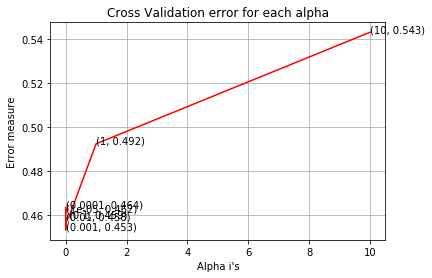

For the value of best alpha 0.001  Train error is : 0.45580009888213596
For the value of best alpha 0.001  Test error is : 0.5429897542717459
Total number of data points : 30000


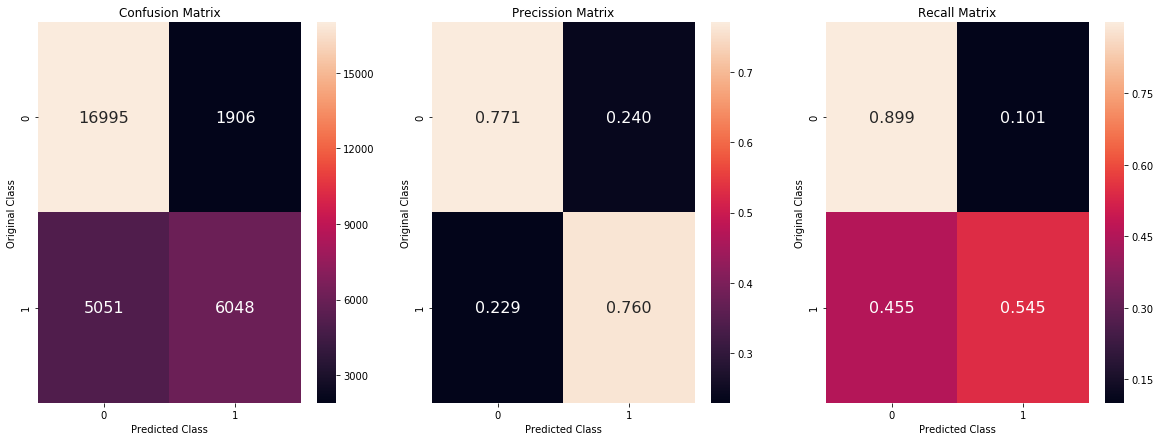

In [49]:
alpha = [10**i for i in range(-5,2)]
log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty = "l2", loss = "log", random_state = 10)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(x_train, y_train)
    y_predicted = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, y_predicted, labels = clf.classes_))
    print("For value of alpha",i," The log loss is",log_loss(y_test, y_predicted, 
                                                             labels = clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, color = "r")
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], txt), (alpha[i], log_error_array[i])) # what, where
plt.grid()
plt.title("Cross Validation error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
logistic_alpha = best_alpha
clf = SGDClassifier(alpha =alpha[best_alpha], penalty="l2", loss="log", random_state=10)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(x_train, y_train)
predicted_y = sig_clf.predict_proba(x_train)
logistic_train_logloss = log_loss(y_train, predicted_y, labels = clf.classes_)
print("For the value of best alpha", alpha[best_alpha]," Train error is :",logistic_train_logloss)
predicted_y = sig_clf.predict_proba(x_test)
logistic_test_logloss = log_loss(y_test, y_predicted, labels = clf.classes_)
print("For the value of best alpha", alpha[best_alpha]," Test error is :", logistic_test_logloss)
predicted_y = np.argmax(predicted_y, axis = 1)
print("Total number of data points :",len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM with hyperparameter tuning


For alpha = 1e-05  the Log loss is : 0.4714074176932026
For alpha = 0.0001  the Log loss is : 0.49136007144000143
For alpha = 0.001  the Log loss is : 0.49604523062046174
For alpha = 0.01  the Log loss is : 0.49515164115950866
For alpha = 0.1  the Log loss is : 0.5448843649896918
For alpha = 1  the Log loss is : 0.565429384375468
For alpha = 10  the Log loss is : 0.6265561023437333


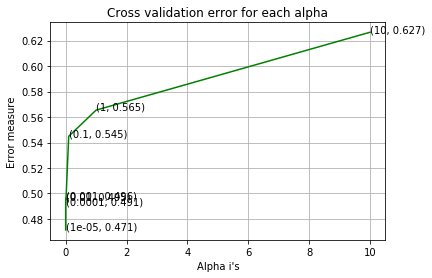

For best value of alpha 1e-05  Train error is : 0.4763562882724296
For best value of alpha 1e-05  Test error is : 0.4714074176932026
Total number of data points 30000


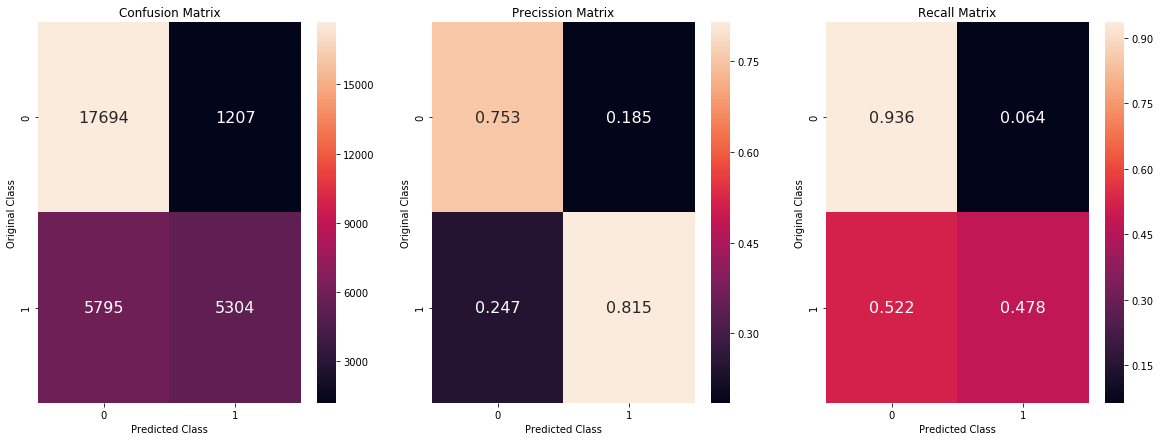

In [50]:
alpha = [10**x for x in range(-5, 2)]
log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, loss = "hinge", penalty = "l1", random_state = 10)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(x_train, y_train)
    y_predicted = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, y_predicted, labels = clf.classes_))
    print("For alpha =",i," the Log loss is :",log_loss(y_test, y_predicted, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, color = "g")
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], txt), (alpha[i], log_error_array[i]))
plt.grid()
plt.title("Cross validation error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
svm_alpha = best_alpha
clf = SGDClassifier(alpha = alpha[best_alpha], loss = "hinge", penalty = "l1", 
                   random_state = 10)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(x_train, y_train)
y_predicted = sig_clf.predict_proba(x_train)
svm_train_logloss = log_loss(y_train, y_predicted, labels = clf.classes_)
print("For best value of alpha",alpha[best_alpha]," Train error is :", svm_train_logloss)
y_predicted = sig_clf.predict_proba(x_test)
svm_test_logloss = log_loss(y_test, y_predicted, labels = clf.classes_)
print("For best value of alpha",alpha[best_alpha]," Test error is :", svm_test_logloss)
y_predicted = np.argmax(y_predicted, axis = 1)
print("Total number of data points", len(y_predicted))
plot_confusion_matrix(y_test, y_predicted)

# XGBoost with hyperparameter tuning using RandomizedSearchCV

In [51]:
word2tfidf = dict(zip(tf_idf_vect.get_feature_names(), tf_idf_vect.idf_))
# Here insted of using W2V we are using GLOVE(Global vectors) model to convert word to vectors.
nlp = spacy.load("en_core_web_sm")

vecs1 = []

for qu1 in tqdm(list(df["question1"])):
    doc1 = nlp(qu1)
    
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        vec1 = word1.vector
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis = 0) # axis = 0 means column
    vecs1.append(mean_vec1)

df["q1_feats_m"] = list(vecs1)



In [52]:
vecs2 = []
for qu2 in tqdm(list(df["question2"])):
    doc2 = nlp(qu2)
    
    mean_vector = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        vec2 = word2.vector
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vector += vec2 * idf
    mean_vector = mean_vector.mean(axis = 0) # axis = 0 means columns
    vecs2.append(mean_vector)
    
df["q2_feats_m"] = list(vecs2)
df.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m
74057,74057,126989,108331,How could I start my business?,How should I start business?,11,1,30,28,6,...,1.0,1.0,5.5,89,86,75,89,0.448276,"[37.06455785036087, 8.627201080322266, -18.663...","[24.01224985718727, -3.768834948539734, -27.99..."
281368,281368,53463,326505,How do I access BIOS menu on a Sony Vaio E ser...,How do I access BIOS menu on a Sony VaioVGN-NR...,5,1,85,93,20,...,1.0,0.0,20.0,94,89,93,96,0.500000,"[170.51395344734192, -85.90778398513794, -12.1...","[172.26263165473938, -89.06777334213257, -45.2..."
108,108,217,218,How competitive is the hiring process at Repub...,How competitive is the hiring process at S & T...,1,5,55,52,9,...,1.0,1.0,9.5,89,84,89,96,0.803922,"[-24.298497438430786, -80.5129406452179, 9.122...","[-12.587837934494019, -82.09982705116272, 3.90..."
50340,50340,89446,89447,What are the ways find circumcenter of a trian...,"Given 3 points in the Cartesian plane, how can...",1,1,65,164,12,...,0.0,18.0,21.0,12,37,41,61,0.227273,"[87.82076334953308, -63.96775281429291, -46.16...","[210.6512449979782, -64.00393670797348, -89.50..."
319372,319372,11055,4433,What must I do to have good handwriting?,How I can be good at handwriting?,6,2,40,33,8,...,0.0,1.0,7.5,65,70,59,72,0.382353,"[59.3484862446785, 2.5387719869613647, -59.416...","[12.976634338498116, 3.416797637939453, -68.42..."


In [53]:
df = df.drop(["qid1", "qid2", "question1", "question2"], axis = 1)
df_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index = df.index)
df_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index = df.index)
df = df.drop(["q1_feats_m", "q2_feats_m"], axis = 1)
df.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,longest_substr_ratio
74057,74057,11,1,30,28,6,5,4.0,11.0,0.363636,...,0.666656,1.0,1.0,1.0,5.5,89,86,75,89,0.448276
281368,281368,5,1,85,93,20,19,17.0,37.0,0.459459,...,0.849996,1.0,1.0,0.0,20.0,94,89,93,96,0.500000
108,108,1,5,55,52,9,11,8.0,20.0,0.400000,...,0.799992,1.0,1.0,1.0,9.5,89,84,89,96,0.803922
50340,50340,1,1,65,164,12,30,6.0,38.0,0.157895,...,0.233333,0.0,0.0,18.0,21.0,12,37,41,61,0.227273
319372,319372,6,2,40,33,8,7,3.0,15.0,0.200000,...,0.374995,1.0,0.0,1.0,7.5,65,70,59,72,0.382353


In [54]:
df_q1["id"] = df["id"]
df_q2["id"] = df["id"]
df = df.merge(df_q1, on = "id", how = "left")
df = df.merge(df_q2, on = "id", how = "left")
df = df.drop(["id"], axis = 1)
df.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,freq_q1+freq_q2,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,11,1,30,28,6,5,4.0,11.0,0.363636,12,...,7.986906,-16.085717,28.626723,15.990872,13.868688,-6.155153,48.876645,-3.725190,10.101359,32.425499
1,5,1,85,93,20,19,17.0,37.0,0.459459,6,...,91.440757,-18.397345,109.063860,87.187807,1.093466,-26.391485,26.536588,50.598825,-133.215085,94.432490
2,1,5,55,52,9,11,8.0,20.0,0.400000,6,...,57.618410,-25.675825,9.567170,5.173123,18.241207,-44.557572,-98.018642,43.259127,-32.089567,58.786907
3,1,1,65,164,12,30,6.0,38.0,0.157895,2,...,135.938507,-43.579266,153.678097,108.619549,-46.042974,-55.727384,25.151080,292.080682,-122.431695,-20.927333
4,6,2,40,33,8,7,3.0,15.0,0.200000,8,...,29.725024,-21.136151,41.521592,26.656428,-12.567412,24.529387,71.898301,20.553548,-40.716914,29.676258


In [55]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, stratify = Y, test_size = 0.3)
print("Number of points in train data", x_train.shape[0])
print("Number of points in test data", x_test.shape[0])

Number of points in train data 70000
Number of points in test data 30000


In [56]:
params = {"max_depth" : [2, 4, 6, 8], "n_estimators" : [80, 100, 120, 150], 
          "reg_alpha" : [0, 0.1, 0.5, 1], "reg_lambda" : [0, 0.1, 0.5, 1],
          "learning_rate" : [0.01, 0.02, 0.1], "colsample_bytree" : [0.3, 0.5, 0.7]}
clf = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = params, 
                         scoring = "neg_log_loss")
clf.fit(x_train, y_train)
optimal_params = clf.best_params_ # returns a dictionary
predict_y = clf.predict_proba(x_train)
gbdt_train_logloss = log_loss(y_train, predict_y, labels = clf.classes_)
print("The train log loss is :", gbdt_train_logloss)
predict_y = clf.predict_proba(x_test) #predict_y is probability not a decision
gbdt_test_logloss = log_loss(y_test, predict_y, labels = clf.classes_)
print("The test log loss is :", gbdt_test_logloss)
print(clf.best_score_)

The train log loss is : 0.27258065065289333
The test log loss is : 0.3381815760792856
-0.3393685193726847


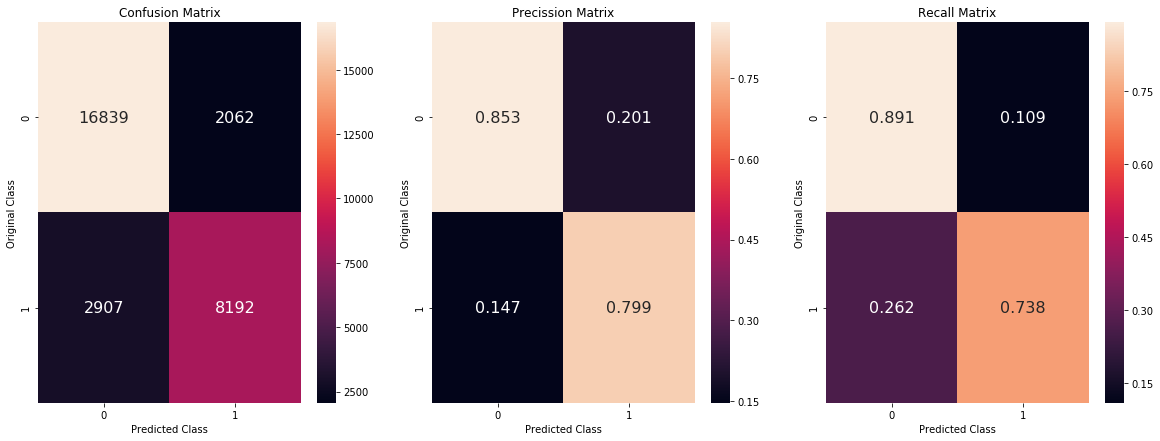

In [57]:
predicted_y = np.argmax(predict_y, axis = 1) # axis =1 means rows
plot_confusion_matrix(y_test, predicted_y)

# Conclusions

In [65]:
p = PrettyTable(field_names = ['Model','Vectorizer',"Hyperparameters",
                               'Train Log-Loss','Test Log-Loss'])

p.add_row(['Random', 'TFIDF', "-", "-", random_test_logloss])
p.add_row(["Logistic Regression", 'TFIDF', "alpha : "+str(logistic_alpha) , 
           logistic_train_logloss, logistic_test_logloss])
p.add_row(["Linear SVM", 'TFIDF', "alpha : "+str(svm_alpha), svm_train_logloss, svm_test_logloss])
p.add_row(["GBDT", 'TfidfGLOVE', "max_depth : "+str(optimal_params["max_depth"])+"\n"+
                                 " n_estimators : "+str(optimal_params["n_estimators"])+"\n"+
                                 " reg_alpha : "+str(optimal_params["reg_alpha"])+"\n"+
                                 " reg_lambda : "+str(optimal_params["reg_lambda"])+"\n"+
                                 " learning_rate : "+str(optimal_params["learning_rate"])+"\n"+
                                 " colsample_bytree : "+str(optimal_params["colsample_bytree"])+"\n", 
                                  gbdt_train_logloss, gbdt_test_logloss])
print(p)

+---------------------+------------+-------------------------+---------------------+--------------------+
|        Model        | Vectorizer |     Hyperparameters     |    Train Log-Loss   |   Test Log-Loss    |
+---------------------+------------+-------------------------+---------------------+--------------------+
|        Random       |   TFIDF    |            -            |          -          | 0.8884516122204944 |
| Logistic Regression |   TFIDF    |        alpha : 2        | 0.45580009888213596 | 0.5429897542717459 |
|      Linear SVM     |   TFIDF    |        alpha : 0        |  0.4763562882724296 | 0.4714074176932026 |
|         GBDT        | TfidfGLOVE |      max_depth : 6      | 0.27258065065289333 | 0.3381815760792856 |
|                     |            |    n_estimators : 150   |                     |                    |
|                     |            |       reg_alpha : 1     |                     |                    |
|                     |            |      reg_

# Summary

* Step-1--> First and foremost I performed some basic exploratory data analysis.
* Step-2--> Then I performed some basic feature engineering without any data preprocessing.
* Step-3--> Then I did preprocessing of data.
* Step-4--> After preprocessing I did some advanced Feature engineering using fuzzywuzzy 
library in python.
* Step-5--> Then I analyzed duplicate and non_duplicate questions seperately using WordCloud.
* Step-6--> Then I merged the train.csv, df_fe_without_preprocessing_test.csv 
and nlp_features_train.csv into one data frame.
* Step-7--> Then I randomly sampled 100K datapoints and splitted into train and
test dataset in the ratio 7:3.
* Step-8--> Then I trainned my TfidfVectorizer onto list(x_train["question1"]) +
list(x_train["question2"])
* Step-9--> Then i modified my x_train as follows: x_train = tfidf_features_for
question1 + tfidf_features_for question2 + other engineered features. In the 
similar way I generated x_test
* Step-10--> I choose log_loss as performance matrix because I was solving a
binary classification problem and it penalizes our predictected probabilities
according to the class label.
* Step-11--> Before applying any model first of all I set a benchmark by trainning
a random model.
* Step-12--> Then I applied Logistic Regression because it actually minimizes 
logloss in its implementation.
* Step-13--> I calibrated my logistic regression model so that I get sensible
probabilities as output.
* Step-14--> The hyperparameter that I was tuning was alpha. I also plotted 
confusion matrix, Precission Matrix and Recall Matrix for test datasets 
to verify the results.
* Step-15--> According to me I was overfitting my model as there was a 
considerable difference between train_error and test_error.
* Step-16--> Next I trainned using Linear SVM model because it is somewhat
similar to logistic regression geometrically.
* Step-17--> Here I followed the same procedure as I followed in Logistic 
Regression.
* Step-18--> The train and test error verified that i was not overfitting.
* Step-19--> Since now I am not overfitting I also want to confirm that I am
not underfitting as well. For this I decided to train using a more complex 
model i.e. GBDT.
* Step-20--> In this I made a slight change in the dataset. To reduce the 
dimensionality instead of using thidf vectors I used Tfidf-GLOVE(Global Vectors).
* Step-21--> The hyperparameters I tunned were: max_depth, n_estimators, reg_alpha,
reg_lambda, learning_rate, colsample_bytree.
* Step-22--> The log_loss that I now obtained was much less than that obtained
in logistic regression and svm and also there was not much difference between
train_error(0.32) and test_error(0.35).
* Step-23--> At the end I plotted the PrettyTable which had every value for every
model that I trainned quantitatively.
* Step-24--> At the end I obtained a model that had low log_loss and was neither
overfitting nor underfitting.